In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
import tarfile
import os
from torchvision.utils import make_grid
from torch.utils.data import random_split
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

## downloading dataset 

In [2]:
download_path  = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

download_url(url = download_path,
            root = ".")

Using downloaded and verified file: .\cifar10.tgz


In [3]:
# extracting dataset into data directory 

with tarfile.open("./cifar10.tgz", "r:gz") as tar : 
    tar.extractall("./data")

In [3]:
# folder / class names 

data_dir = "./data/cifar10"
print(os.listdir(data_dir))

classes = os.listdir(data_dir+"/train")

print(classes)


['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# example files 

airplane_files = os.listdir(data_dir+"/train/airplane")
print("Total airplane image : ", len(airplane_files))

print("First 5 file name : ",airplane_files[:5])

Total airplane image :  5000
First 5 file name :  ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [5]:
horse_sample = os.listdir(data_dir+"/train/horse")
print("Total horse image : ", len(horse_sample))

print("First 5 file name : ",horse_sample[:5])

Total horse image :  5000
First 5 file name :  ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


### Converting images and labels into Dataset using *Pytorch's* **ImageFolder**

In [6]:
dataset = ImageFolder(data_dir+"/train" , transform = ToTensor())

label =  0
Image shape :  torch.Size([3, 32, 32])


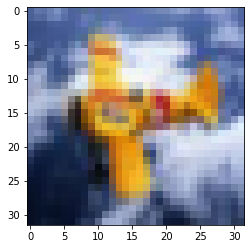

In [7]:
image , label = dataset[22]
print("label = ", label)
plt.imshow(image.permute(1,2,0));
print("Image shape : ",image.shape)

In [8]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# defining a function for showing image from dataset 

def image_show(image, label):
    print("Label : ",dataset.classes[label] , "("+str(label)+")")
    plt.imshow(image.permute(1,2,0))
    

Label :  airplane (0)


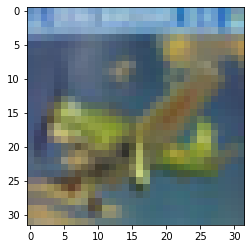

In [10]:
image_show(*dataset[95])

Label :  automobile (1)


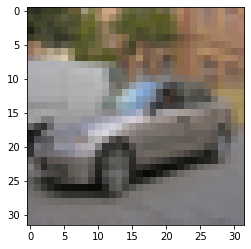

In [11]:
image_show(*dataset[9984])

### converting dataset into dataloader

In [12]:
random_seed = 42

torch.manual_seed(random_seed)

In [13]:
# splitting the data into train and validation set 

val_size = 5000
train_size = len(dataset) - val_size

train_ds , val_ds  = random_split(dataset , [train_size, val_size])

In [14]:
len(train_ds) , len(val_ds) , len(dataset)

(45000, 5000, 50000)

In [15]:
# converting into data loader 
batch_size = 128

train_loader = DataLoader(train_ds, batch_size,shuffle = True, num_workers = 2 , pin_memory = True)
valid_loader = DataLoader(val_ds, batch_size*2 , num_workers = 2, pin_memory=True)

In [16]:
# defining function for showing a batch of data 

def show_batch(dl):
    for images , labels in dl :
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

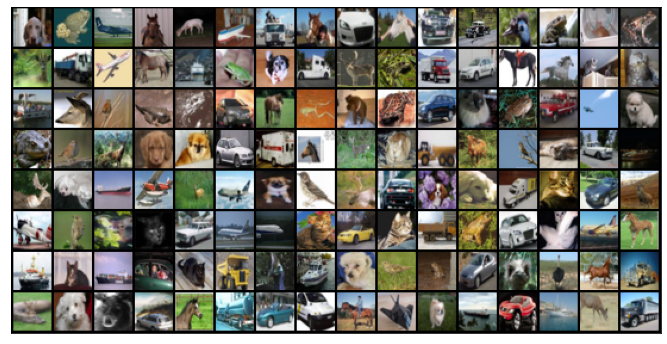

In [17]:
show_batch(train_loader)

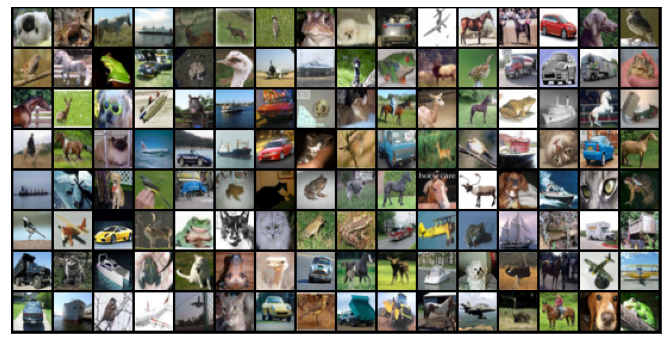

In [18]:
show_batch(train_loader)

## Single convolutional layer followed by max-pooling layer

In [19]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [20]:
for images , labels in train_loader:
    print("input image shape : ", images.shape)
    out = simple_model(images)
    print("Output shape : ", out.shape)
    break

input image shape :  torch.Size([128, 3, 32, 32])
Output shape :  torch.Size([128, 8, 16, 16])


In [21]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images , labels  = batch
        output = self(images) # generates output
        loss = F.cross_entropy(output, labels) # generates loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        output = self(images)  # generates output
        loss = F.cross_entropy(output, labels) # generates loss on validation step 
        acc = accuracy(output, labels) # generates accuracy on validation set 
        return {"val_acc": acc, "val_loss": loss}
    
    def validation_epoch_end(self, output):
        batch_loss = [x['val_loss'] for x in output]
        epoch_loss = torch.stack(batch_loss).mean() # combine losses
        batch_acc = [x['val_acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()  # combine accurecies
        
        return {"val_acc": epoch_acc.item(), "val_loss": epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch[{epoch}] , train loss : {result['train_loss']:.3f} ,val loss : {result['val_loss']:.3f} , val accuracy : {result['val_acc']:.3f}")
        
def accuracy(output, labels):
    _ , preds = torch.max(output, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

## from jovian

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class Cfir10CnnModel(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        
        self.network = nn.Sequential(
            
            
            nn.Conv2d(3, 32, kernel_size= 3 , padding=1),
            nn.ReLU(),   # Rectified Linear Unit activition function for adding non linearity to the model 
            nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output 64 x 16 x 16
            
            
            nn.Conv2d(64, 128 , kernel_size=3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 , 128 , kernel_size= 3 , stride = 1 , padding = 1),
            nn.ReLU(), 
            nn.MaxPool2d(2,2) , # output 128 x 8 x 8
            
            nn.Conv2d(128 , 256 , kernel_size=3, stride =1 , padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size= 3, stride= 1 , padding = 1), 
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output 256 x 4 x 4
            
            
            nn.Flatten(),
            nn.Linear(256*4*4 , 1024),
            nn.ReLU(), 
            nn.Linear(1024, 512) , 
            nn.ReLU() , 
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)
    
        
        

In [23]:
model = Cfir10CnnModel()
model

Cfir10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featu

In [24]:
for images , labels in train_loader: 
    print("Image shape : " , images.shape)
    output = model(images)
    print("output shape : " , output.shape)
    print("Out[0] : " , output[0])
    print("each output length : ", len(output[0]))
    break

Image shape :  torch.Size([128, 3, 32, 32])
output shape :  torch.Size([128, 10])
Out[0] :  tensor([ 0.0106,  0.0375,  0.0081, -0.0291, -0.0302, -0.0390, -0.0417,  0.0185,
         0.0232,  0.0252], grad_fn=<SelectBackward>)
each output length :  10



### Getting GPU ready 

In [25]:

def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(x , device ) for x in data]
    return data.to(device , non_blocking = True)


class DeviceDataLoader():
    
    def __init__(self, dl, device):
        
        self.dl = dl 
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [26]:
device  = get_default_device()
device

device(type='cuda')

In [27]:
# taking all the data loaders and our model to the gpu ( or in available device)
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

to_device(model, device);

### defining fit function 

In [28]:
@torch.no_grad()
def evalute(model,val_loader):
    model.eval()
    
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



def fit(epochs, lr, model, train_loader, valid_loader , opt_func = torch.optim.SGD):
    
    history = []
    
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in tqdm(range(epochs)):
        
        # training phase 
        model.train()
        train_losses = []
        
        for batch in train_loader: 
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()
            
        
        # validation phase 
        
        result = evalute(model, valid_loader)
        result["train_loss"]  = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [29]:
model = to_device(Cfir10CnnModel(), device)


In [30]:
evalute(model,valid_loader)

{'val_acc': 0.09523207694292068, 'val_loss': 2.303215742111206}

In [31]:
epochs = 10
lr = 0.001
opt_func = torch.optim.Adam

In [32]:
from tqdm import tqdm
history = fit(epochs=epochs,lr=lr, model=model,train_loader=train_loader,valid_loader=valid_loader,opt_func=opt_func)

 10%|████▏                                     | 1/10 [02:32<22:48, 152.03s/it]

Epoch[0] , train loss : 1.837 ,val loss : 1.503 , val accuracy : 0.445


 20%|████████▍                                 | 2/10 [06:01<24:45, 185.69s/it]

Epoch[1] , train loss : 1.337 ,val loss : 1.208 , val accuracy : 0.561


 30%|████████████▌                             | 3/10 [09:02<21:26, 183.77s/it]

Epoch[2] , train loss : 1.048 ,val loss : 0.976 , val accuracy : 0.653


 40%|████████████████▊                         | 4/10 [12:13<18:39, 186.54s/it]

Epoch[3] , train loss : 0.858 ,val loss : 0.904 , val accuracy : 0.689


 50%|█████████████████████                     | 5/10 [14:56<14:50, 178.04s/it]

Epoch[4] , train loss : 0.727 ,val loss : 0.780 , val accuracy : 0.725


 60%|█████████████████████████▏                | 6/10 [18:08<12:10, 182.67s/it]

Epoch[5] , train loss : 0.605 ,val loss : 0.735 , val accuracy : 0.751


 70%|█████████████████████████████▍            | 7/10 [21:42<09:38, 192.88s/it]

Epoch[6] , train loss : 0.508 ,val loss : 0.787 , val accuracy : 0.743


 80%|█████████████████████████████████▌        | 8/10 [25:19<06:41, 200.72s/it]

Epoch[7] , train loss : 0.411 ,val loss : 0.744 , val accuracy : 0.759


 90%|█████████████████████████████████████▊    | 9/10 [28:22<03:15, 195.23s/it]

Epoch[8] , train loss : 0.331 ,val loss : 0.766 , val accuracy : 0.766


100%|█████████████████████████████████████████| 10/10 [31:54<00:00, 191.43s/it]

Epoch[9] , train loss : 0.256 ,val loss : 0.842 , val accuracy : 0.781


In [36]:
def plot_accurecies(history):
    accuracy = [x['val_acc'] for x in history]
    plt.plot(accuracy, "-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Vs Num of Epochs");

In [37]:
def plot_losses(history):
    train_loss = [x['train_loss'] for x in history]
    valid_loss = [x['val_loss'] for x in history]
    
    plt.plot(train_loss , "-bx")
    plt.plot(valid_loss , "-rx")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.title("Loss Vs Num of Epochs");

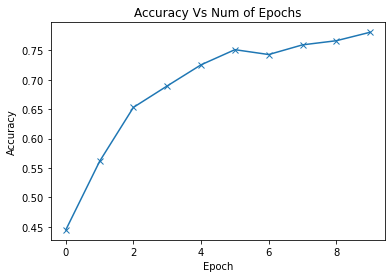

In [38]:
plot_accurecies(history)

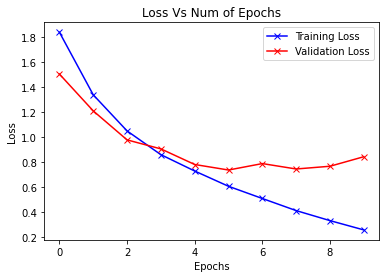

In [39]:
plot_losses(history)

## Testing the model 

In [40]:
test_dataset = ImageFolder(data_dir+"/train" , ToTensor())

In [41]:
def predict_image(image, model):
    
    xb  = to_device(image.unsqueeze(0) , device)
    yb = model(xb)
    
    _, preds = torch.max(yb,dim=1)
    
    return dataset.classes[preds[0].item()]
    

Actual image :  automobile 	Predicted :  automobile


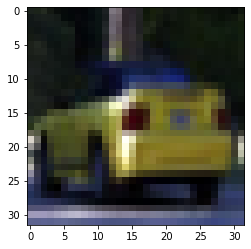

In [46]:
image , label = test_dataset[7742]
plt.imshow(image.permute(1,2,0))
print("Actual image : ",dataset.classes[label], "\tPredicted : ", predict_image(image, model))